# 循环神经网络
本节介绍循环神经网络，下图展示了如何基于循环神经网络实现语言模型。我们的目的是基于当前的输入与过去的输入序列，预测序列的下一个字符。循环神经网络引入一个隐藏变量$H$，用$H_{t}$表示$H$在时间步$t$的值。$H_{t}$的计算基于$X_{t}$和$H_{t-1}$，可以认为$H_{t}$记录了到当前字符为止的序列信息，利用$H_{t}$对序列的下一个字符进行预测。
![avatar][base64str]
[base64str]: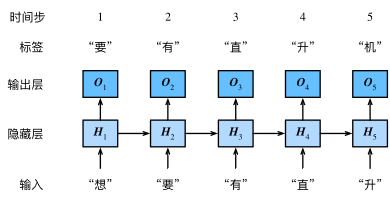

## 循环神经网络的构造

我们先看循环神经网络的具体构造。假设$\boldsymbol{X}_t \in \mathbb{R}^{n \times d}$是时间步$t$的小批量输入，$\boldsymbol{H}_t  \in \mathbb{R}^{n \times h}$是该时间步的隐藏变量，则：


$$
\boldsymbol{H}_t = \phi(\boldsymbol{X}_t \boldsymbol{W}_{xh} + \boldsymbol{H}_{t-1} \boldsymbol{W}_{hh}  + \boldsymbol{b}_h).
$$


其中，$\boldsymbol{W}_{xh} \in \mathbb{R}^{d \times h}$，$\boldsymbol{W}_{hh} \in \mathbb{R}^{h \times h}$，$\boldsymbol{b}_{h} \in \mathbb{R}^{1 \times h}$，$\phi$函数是非线性激活函数。由于引入了$\boldsymbol{H}_{t-1} \boldsymbol{W}_{hh}$，$H_{t}$能够捕捉截至当前时间步的序列的历史信息，就像是神经网络当前时间步的状态或记忆一样。由于$H_{t}$的计算基于$H_{t-1}$，上式的计算是循环的，使用循环计算的网络即循环神经网络（recurrent neural network）。

在时间步$t$，输出层的输出为：


$$
\boldsymbol{O}_t = \boldsymbol{H}_t \boldsymbol{W}_{hq} + \boldsymbol{b}_q.
$$


其中$\boldsymbol{W}_{hq} \in \mathbb{R}^{h \times q}$，$\boldsymbol{b}_q \in \mathbb{R}^{1 \times q}$。


## 从零开始实现循环神经网络

我们先尝试从零开始实现一个基于字符级循环神经网络的语言模型，这里我们使用周杰伦的歌词作为语料，首先我们读入数据：

In [17]:
import torch
import torch.nn as nn
import time
import math
import sys


## 参考资料链接

RNN详解
https://blog.csdn.net/zhaojc1995/article/details/80572098

## 习题

选择题

### 1.关于循环神经网络描述错误的是：

A.在同一个批量中，处理不同语句用到的模型参数$W_{h}$和$b_{h}$是一样的

B.循环神经网络处理一个长度为$T$的输入序列，需要维护$T$组模型参数

C. 各个时间步的隐藏状态$H_{t}$不能并行计算

D. 可以认为第$t$个时间步的隐藏状态$H_t$包含截止到第$t$个时间步的序列的历史信息

答案： B

答案解释
选项1：批量训练的过程中，参数是以批为单位更新的，每个批次内模型的参数都是一样的。

选项2：循环神经网络通过不断循环使用同样一组参数来应对不同长度的序列，故网络的参数数量与输入序列长度无关。

选项3：隐状态$H_t$的值依赖于$H_1, ..., H_{t-1}$，故不能并行计算。

选项4：可以这么认为，详见视频中2分40秒到3分10秒。


### 2.关于梯度裁剪描述错误的是：

A.梯度裁剪之后的梯度小于或者等于原梯度

B.梯度裁剪是应对梯度爆炸的一种方法

C.裁剪之后的梯度L2范数小于阈值θ\thetaθ

D.梯度裁剪也是应对梯度消失的一种方法

答案：D

答案解释

选项1：正确，参考梯度裁剪的定义。

选项2：正确，参考视频13分40秒左右。

选项3：正确，参考视频14分25秒左右。

选项4：错误，只能应对梯度爆炸。


### 3.关于困惑度的描述错误的是：

A.困惑度用来评价语言模型的好坏

B.困惑度越低语言模型越好

C.有效模型的困惑度应该大于类别个数

答案：C

答案解释

选项1：正确，参考视频19分27秒左右。

选项2：正确，参考视频19分58秒左右。

选项3：错误，一个随机分类模型（基线模型）的困惑度等于分类问题的类别个数，有效模型的困惑度应小于类别个数。

### 4.关于采样方法和隐藏状态初始化的描述错误的是：

A.采用的采样方法不同会导致隐藏状态初始化方式发生变化

B.采用相邻采样仅在每个训练周期开始的时候初始化隐藏状态是因为相邻的两个批量在原始数据上是连续的

C.采用随机采样需要在每个小批量更新前初始化隐藏状态是因为每个样本包含完整的时间序列信息

答案：C

答案解释

选项1：正确，参考视频20分20秒到21分05秒。

选项2：正确，参考视频20分30秒左右

选项3：错误，随机采样中每个样本只包含局部的时间序列信息，因为样本不完整所以每个批量需要重新初始化隐藏状态。参考视频22分0秒左右。
